## <center> Go to piazza and open today's lecture notes in the hub! </center>
## <center> https://piazza.com/class/jzioyk40mhs6r2 </center>
## <center> Let's go to tophat for attendance! </center>
## <center> https://app.tophat.com/e/245218 </center>

## Project descriptions
- Don't throw features out based on your hunch!
   - Saying that 'I don't think this feature is predictive so I dropped it' is a big no-no.
   - You should provide a data-driven argument why you drop a feature (mutual info or f-test is a minimum).
- LabelEncoder is not to be used on features.
- If a categorical feature contains only 0s and 1s, there is no need to do preprocessing.
- If a continuous feature is already between 0 and 1 (e.g., a fraction), there is no need to do preprocessing.

- if UCI says 'missing values are represented with 999', you shouldn't immediately apply a min-max or standard scaler to the feature
   - replace 999 with np.nan
- Make an informed decision on what you do with your missing values!
   - mean/median imputation is another big no-no
   - run the mcar test
   - count the fraction of points with missing values, and fraction of missing values per columns
   - then decide what to do based on the findings
- Please reference previous work!
   - cite papers
   - add links to kaggle kernels
- Please clean up your github repos

## Mud card
- **Can you consider a classification problem with >2 classes to be a series of binary classifcation problems (each with class of interest vs all other classes)?**
   - yes, that's called one-vs-all classifier
   - the other (more computationally intensive) approach is a one-vs-one classifier
   - more info on this [here](https://scikit-learn.org/stable/modules/multiclass.html)

- **Can we play with the training data itself like sampling to deal with unbalanced data?**
- **It would be nice to have links to discussions of when a dataset is imbalanced**
   - imbalanced problems are inherently difficult
   - undersampling the majority class or oversampling the minority class are often done to improve the balance
      - such approaches can be misleading because when the model is deployed, the data remain as imbalanced as before
      - confusion matrix example
   - my advice:
      - find simple rules that let you exclude a large fraction of condition negative samples **before** ML is done
      - use the f1 score or some other metric that is not based on true negatives
      - some ML algos are better with imbalanced data than others, try a few 
         - e.g., tree-based methods often let you assign larger weights to the minority class

- **Can you explain what f-score does and how to use it to evaluate the performance of a classifier?**
- **What's the theory behind f_1 score?**
   - f_beta = (1 + beta^2) P R / ( beta^2 * P + R)
   - P alone and R alone are often not enough to evaluate a classifier because they are based on only 2 elements of the confusion matrix
   - the f score is their weighted harmonic mean
      - beta = 1: the weight of P and R are the same
      - beta < 1: more weight to precision
      - beta > 1: more weight to recall
- read more on model evaluation [here](https://scikit-learn.org/stable/modules/model_evaluation.html)

## Evaluation metrics in supervised ML, part 2, predicted probabilities and regression

By the end of this lecture, you will be able to
- Summarize the ROC and precision-recall curves, and the logloss metric
- Describe the most commonly used regression metrics


## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- **Summarize the ROC and precision-recall curves, and the logloss metric**
- <font color='LIGHTGRAY'>Describe the most commonly used regression metrics</font>


### The ROC curve
- Receiver Operating Characteristic
   - x axis: false positive rate (fpr = FP / (FP + TN))
   - y axis: true positive rate (R = TP / (TP + FN))
   - the curve shows fpr and R value pairs for various class 1 critical probabilities
- upper left corner: perfect predictor
- diagonal point: chance level predictions
- lower right corner: worst predictor

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
df = pd.read_csv('data/true_labels_pred_probs.csv')

y_true = df['y_true']
pred_prob_class1 = df['pred_prob_class1']

fpr = np.zeros(len(y_true))
tpr = np.zeros(len(y_true))

p_crits = np.sort(pred_prob_class1) # the sorted predicted probabilities serve as critical probabilities

for i in range(len(p_crits)):
    p_crit = p_crits[i]
    
    y_pred = np.zeros(len(y_true))
    y_pred[pred_prob_class1 < p_crit] = 0
    y_pred[pred_prob_class1 >= p_crit] = 1
    
    C = confusion_matrix(y_true,y_pred) 
    
    tpr[i] = C[1,1]/(C[1,0]+C[1,1])
    fpr[i] = C[0,1]/(C[0,0]+C[0,1])
    

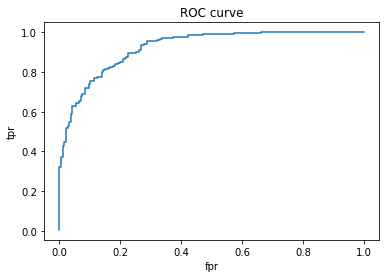

In [2]:
plt.plot(fpr,tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## Exercise 1
What's the (fpr,tpr) coordinate on the ROC curve if p_crit = 1?

1 90 0.9945233669173535
21 90 0.8211293919918673
41 90 0.6028657812522096
61 90 0.4129907535897641
81 90 0.1286071446570628


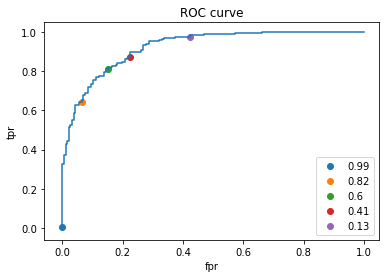

In [3]:
from sklearn.metrics import roc_curve

fpr,tpr,p_crits = roc_curve(y_true,pred_prob_class1)

plt.plot(fpr,tpr)
for i in np.arange(len(p_crits))[1::20]:
    print(i,len(p_crits),p_crits[i])
    plt.scatter(fpr[i],tpr[i],label=str(np.around(p_crits[i],2)))
plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC curve')
plt.show()

## ROC AUC
- ROC is useful but it is not a single number metric
   - it cannot be directly used to compare various classification models
- summary statistics based on the ROC curve (for a complete list, see [here](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Further_interpretations))
- most commonly used metric is ROC AUC - ROC Area Under the Curve
   - ROC AUC 0.5 is a chance-level classifier
   - AUC > 0.5 is above chance-level predictor
   - AUC < 0.5 is a bad predictor

In [4]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true,pred_prob_class1))

0.9236524315231854


## Precision-recall curve
- the drawback of ROC is that it uses TN, not good for imbalanced problems.
- the precision-recall curve doesn't use TN, ideal for imbalanced problems.

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score # the AUC of the P-R curve

p,r,p_crits = precision_recall_curve(y_true,pred_prob_class1)

print(average_precision_score(y_true,pred_prob_class1))

0.9315588971251673


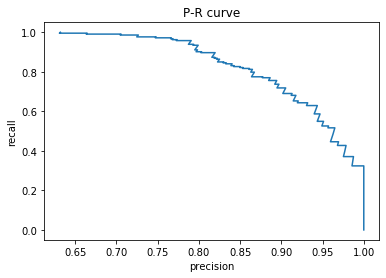

In [14]:
plt.plot(p,r)
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('P-R curve')
plt.show()


## Exercise 2
What's the (p,r) coordinate on the curve if p_crit = 0?

0 337 0.03488548943221837
100 337 0.3608915590301473
200 337 0.8697218168754424
300 337 0.9683559426556864


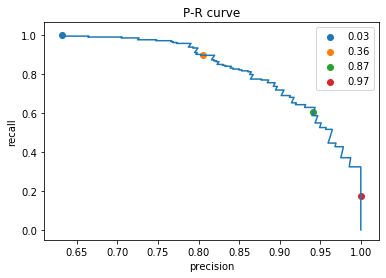

In [7]:
plt.plot(p,r)
for i in np.arange(len(p_crits))[::100]:
    print(i,len(p_crits),p_crits[i])
    plt.scatter(p[i],r[i],label=str(np.around(p_crits[i],2)))
plt.legend()
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('P-R curve')
plt.show()

## The logloss metric

### <center>$logloss = - \frac{1}{N}\sum (y_{true}\ln(p_{pred}) + (1-y_{true})(1-\ln(1-p_{pred})))$</center>
- $p_{pred}$ is the predicted probability of the **positive class**
- the predicted probabilities are not converted into predicted classes
- two scenarios:
   - y_true = 0 - left term disappears
   - y_true = 1 - right term disappears
- log(0) is undefined
   - $p_{pred}$ is replaced with $\max(\min(p,1-10^{-15}),10^{-15})$ to avoid this issue

### The extreme cases
- the classifier is confidently wrong
   - $p_{pred} = 10^{-15}$ for points in class 1
   - $p_{pred} = 1 - 10^{-15}$ for points in class 0
<center>$logloss = -\frac{1}{N}\sum \ln(10^{-15}) = -\ln(10^{-15})$</center>
<center> $logloss \sim  34.5  $</center>

- the classifier is correct
   - $p_{pred} = 10^{-15}$ for points in class 0
   - $p_{pred} = 1 - 10^{-15}$ for points in class 1
<center>$logloss = -\frac{1}{N}\sum (1-0)(1-\ln(1-10^{-15})) = 10^{-15}$ for class 0</center>
<center>$logloss = -\frac{1}{N}\sum 1*\ln(1-10^{-15}) = 10^{-15}$ for class 1</center>
<center>$logloss \sim 0$</center>



In [8]:
from sklearn.metrics import log_loss
print(log_loss(y_true,pred_prob_class1))
help(log_loss)

0.35015190545328556
Help on function log_loss in module sklearn.metrics.classification:

log_loss(y_true, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)
    Log loss, aka logistic loss or cross-entropy loss.
    
    This is the loss function used in (multinomial) logistic regression
    and extensions of it such as neural networks, defined as the negative
    log-likelihood of the true labels given a probabilistic classifier's
    predictions. The log loss is only defined for two or more labels.
    For a single sample with true label yt in {0,1} and
    estimated probability yp that yt = 1, the log loss is
    
        -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
    
    Read more in the :ref:`User Guide <log_loss>`.
    
    Parameters
    ----------
    y_true : array-like or label indicator matrix
        Ground truth (correct) labels for n_samples samples.
    
    y_pred : array-like of float, shape = (n_samples, n_classes) or (n_samples,)
        P

## <font color='LIGHTGRAY'> Evaluation metrics in supervised ML, part 2, predicted probabilities and regression</font>

<font color='LIGHTGRAY'>By the end of this lecture, you will be able to</font>
- <font color='LIGHTGRAY'>Summarize the ROC and precision-recall curves, and the logloss metric</font>
- **Describe the most commonly used regression metrics**


## Regression metrics
- the target variable is continuous
- the predicted values are also continuous
- regression metrics measure some type of difference between y (true values) and y' (predicted values)

### Mean Squared Error 

### <center>$MSE(y,y') = \frac{1}{n}\sum_{i=1}^{n}(y_i-y_i')^2$</center>

<center><img src="figures/polifit_1.jpg" width="450"></center>

#### The unit of MSE is not the same as the target variable.

### Root Mean Square Error

### <center>$RMSE(y,y') = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i-y_i')^2}$</center>


### Mean Absolute Error

### <center>$MAE(y,y') = \frac{1}{n}\sum_{i=1}^{n}|y_i-y_i'|$</center>

#### Both RMSE and MAE have the same unit as the target variable.


## R2 score - coefficient of determination

### <center>$R^2(y,y') = 1 - \frac{\sum_{i=1}^{n}(y_i-y_i')^2}{\sum_{i=1}^{n}(y_i-\bar{y})^2}$,</center>
<center>where $\bar{y}$ is the mean of $y$.</center>

- R2 = 1 is the perfect regression model ($y == y'$)
- R2 = 0 is as good as a constant model that always predicts the expected value of y ($\bar{y}$)
- R2 < 0 is a bad regression model

#### R2 is dimensionless.

In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

- RMSE is not implemented in sklearn, but you can calculate it as `np.sqrt(mean_squared_error(y_true,y_pred))`
- you can find more on regression metrics [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

Now you can
- Summarize the ROC and precision-recall curves, and the logloss metric
- Describe the most commonly used regression metrics
